In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [43]:
data_train_csv = pd.read_csv('datasets/mnist_train.csv')
data_test_csv = pd.read_csv('datasets/mnist_test.csv')

In [44]:
# number of training samples
N_samples = 60000
# number of sample's features
N_features = 784
data_train = np.array(data_train_csv)[:N_samples].T
Y_train = data_train[0].copy()
X_train = data_train[1:].copy()/255

In [45]:
print(X_train.shape)
print(Y_train.shape)

(784, 60000)
(60000,)


In [46]:
data_test = np.array(data_test_csv).T
Y_test = data_test[0].copy()
X_test = data_test[1:].copy() / 255

In [47]:
def initNetwork(K: int) -> (np.ndarray, np.ndarray, np.ndarray, np.ndarray):
    """
    Network initialization.
    
    This function initializes weights and biases for the network of shape 
    (784 - K - 10), where `784` is number of inputs with values in range [0, 1],
    `K` is a number of neurons in the hidden layer and `10` is a number of 
    output classes. Weights and biases are initialized with values from a 
    uniform distribution [0, 1) scaled to (-0.1, 0.1) range.
    
    ### Parameters:
    - `K: int` - number of neurons in the hidden layer
    
    ### Returns:
    - `W1: np.array` - weights matrix, `shape=(K, 784)` for the first layer
    - `b1: np.array` - biases matrix, `shape=(K, 1)` for the first layer
    - `W2: np.array` - weights matrix, `shape=(10, K)` for the second layer
    - `b2: np.array` - biases matrix, `shape=(10, 1)` for the second layer
    """
    W1 = np.random.rand(K, 784) * 0.2 - 0.1
    b1 = np.random.rand(K, 1) * 0.2 - 0.1
    W2 = np.random.rand(10, K) * 0.2 - 0.1
    b2 = np.random.rand(10, 1) * 0.2 - 0.1
    
    return W1, b1, W2, b2

def ReLU(U:np.ndarray):
    """
    Rectified linear unit (ReLU) function.
    
    Applies ReLU function elementwise to the input vector.
    """
    return np.maximum(U, 0)

def softmax(U:np.ndarray):
    """
    Softmax function.
    
    Applies Softmax function element-wise to the input vector.
    """
    exp = np.exp(U)
    return exp / sum(exp)

def forwardPropagation(X:np.ndarray, W1:np.ndarray, b1:np.ndarray, W2:np.ndarray, b2:np.ndarray):
    """
    Execute a forward propagation step.
    
    Starts a forward propagation step with the given parameters. On the network
    with of shape (784 - K - 10), where `784` is number of inputs with values in
    range [0, 1], `K` is a number of neurons in the hidden layer and `10` is a 
    number of output classes.
    
    ### Parameters:
    - `X: np.array` - input vector, `shape=(784, 1)`. Values in range [0, 1]
    - `W1: np.array` - weights matrix for the first layer (input -> hidden)
    - `b1: np.array` - biases matrix for the first layer (input -> hidden)
    - `W2: np.array` - weights matrix for the second layer (hidden -> output)
    - `b2: np.array` - biases matrix for the second layer (hidden -> output)
    
    ### Returns:
    - `U1: np.array` - pre-activation output of the first layer, `shape=(K, 1)`
    - `Y1: np.array` - output of the first layer with applied `ReLU` function
    - `U2: np.array` - pre-activation output of the first layer, `shape=(10, 1)`
    - `Y2: np.array` - output of the second layer with applied `softmax` function
    """
    U1 = W1.dot(X) + b1
    Y1 = ReLU(U1)
    U2 = W2.dot(Y1) + b2
    Y2 = softmax(U2)
    
    return U1, Y1, U2, Y2

def oneHot(Y):
    """
    Create a one-hot matrix for the given array.
    """
    n_elements = Y.size
    one_hot_Y = np.zeros((10, n_elements))
    one_hot_Y[Y, np.arange(n_elements)] = 1
    return one_hot_Y

def MSE(D):
    """
    Calculate the MSE for given array.
    
    ### Parameters:
    - `D: np.array` - array with values `A_1 - A_2`, where `A_1` and `A_2` are
    the two arrays, for which MSE is calculated.
    """
    return np.mean(np.square(D))

def ReLUDerivative(U):
    """
    Return the result of element-wise ReLU derivative calculation.
    """
    return U > 0

def backwardPropagation(U1, Y1, U2, Y2, W1, b1, W2, b2, X, Y):
    """
    Execute a backward propagation step.
    
    Starts a forward propagation step with the given parameters.
    
    ### Parameters:
    - `U1: np.array` - pre-activation output of the first layer, `shape=(K, 1)`
    - `Y1: np.array` - output of the first layer with applied `ReLU` function
    - `U2: np.array` - pre-activation output of the first layer, `shape=(10, 1)`
    - `Y2: np.array` - output of the second layer with applied `softmax` function
    - `W1: np.array` - weights matrix for the first layer (input -> hidden)
    - `b1: np.array` - biases matrix for the first layer (input -> hidden)
    - `W2: np.array` - weights matrix for the second layer (hidden -> output)
    - `b2: np.array` - biases matrix for the second layer (hidden -> output)
    - `X: np.array` - input vector, `shape=(784, 1)`. Values in range [0, 1]
    - `Y: np.array` - array of desired outputs (labels)
    
    ### Returns:
    - `dW1: np.array` - corrections for weights matrix of the first layer
    - `db1: np.array` - corrections for biases matrix of the first layer
    - `dW2: np.array` - corrections for weights matrix of the second layer
    - `db2: np.array` - corrections for biases matrix of the second layer
    - `error: float` - MSE of output compared to labels
    """
    n_samples = Y.size
    one_hot_Y = oneHot(Y)
    D2 = Y2 - one_hot_Y
    error = MSE(D2)
    dW2 = 1/n_samples * (2*D2).dot(Y1.T)
    db2 = 1/n_samples * 2 * np.sum(D2)
    D1 = W2.T.dot(D2) * ReLUDerivative(U1)
    dW1 = 1/n_samples * (2*D1).dot(X.T)
    db1 = 1/n_samples * 2 * np.sum(D1)
    
    return dW1, db1, dW2, db2, error

def updateParams(W1, b1, W2, b2, dW1, db1, dW2, db2, lr, dW1_prev, db1_prev, dW2_prev, db2_prev):
    """
    Update the weights matrices with given corrections.
    
    ### Parameters:
    - `W1: np.array` - weights matrix for the first layer (input -> hidden)
    - `b1: np.array` - biases matrix for the first layer (input -> hidden)
    - `W2: np.array` - weights matrix for the second layer (hidden -> output)
    - `b2: np.array` - biases matrix for the second layer (hidden -> output)
    - `dW1: np.array` - corrections for weights matrix of the first layer
    - `db1: np.array` - corrections for biases matrix of the first layer
    - `dW2: np.array` - corrections for weights matrix of the second layer
    - `db2: np.array` - corrections for biases matrix of the second layer
    - `lr: float` - learning rate
    
    ### Returns:
    - `W1: np.array` - updated weights matrix for the first layer
    - `b1: np.array` - updated biases matrix for the first layer
    - `W2: np.array` - updated weights matrix for the second layer
    - `b2: np.array` - updated biases matrix for the second layer
    """
    ndW1 = (lr * dW1 + (1-lr)*dW1_prev)
    ndb1 = (lr * db1 + (1-lr)*db1_prev)
    ndW2 = (lr * dW2 + (1-lr)*dW2_prev)
    ndb2 = (lr * db2 + (1-lr)*db2_prev)
    W1 -= ndW1
    b1 -= ndb1
    W2 -= ndW2
    b2 -= ndb2
    
    return W1, b1, W2, b2, ndW1, ndb1, ndW2, ndb2


In [50]:
def getPredictions(Y):
    """
    Get predictions from the NN output vector.
    
    ### Parameters:
    - `Y: np.array` - output of the NN
    
    ### Returns:
    - `np.array` - array of classes' numbers
    """
    
    return np.argmax(Y, 0)

def getAccuracy(pred, T):
    """
    Get accuracy of the NN
    
    ### Parameters:
    - `pred: np.array` - array of NN predictions
    - `T: np.array` - desired output (labels)
    
    ### Returns:
    - `float` - percent value of NN accuracy
    """
    
    return np.sum(pred==T)/T.size


def getTestAccuracy(TX, TY, W1, b1, W2, b2):
    predictions = makePredictions(TX, W1, b1, W2, b2)
    accuracy_test = getAccuracy(predictions, TY)
    return accuracy_test

def miniBatchGradientDescend(X, Y, K, lr, iterations, batchSize, TX, TY, decay=0):
    """
    Train the NN using given parameters for a given number of epochs using 
    mini-batch method.
    
    ### Parameters:
    - `X: np.array` - input vector, `shape=(784, 1)`. Values in range [0, 1]
    - `Y: np.array' - array of desired outputs (labels)
    - `K: int` - number of neurons in the hidden layer
    - `lr: float` - learning rate
    - `iterations: int` - number of epochs
    - `batchSize: int` - number of samples in mini-batch
    
    
    ### Returns:
    - `W1: np.array` - trained weights matrix for the first layer
    - `b1: np.array` - trained biases matrix for the first layer
    - `W2: np.array` - trained weights matrix for the second layer
    - `b2: np.array` - trained biases matrix for the second layer
    """
    W1, b1, W2, b2 = initNetwork(K)
    history = {"accuracy_train" : list(),
               "accuracy_test" : list(),
               "error" : list()}
    dW1_prev, db1_prev, dW2_prev, db2_prev = 0.0, 0.0, 0.0, 0.0
    
    predictions = makePredictions(X, W1, b1, W2, b2)
    accuracy_train = getAccuracy(predictions, Y)
    accuracy_test = getTestAccuracy(TX, TY, W1, b1, W2, b2)
    print(f"Train prediction: {accuracy_train} and test: {accuracy_test}")
    
    for i in range(iterations):
        # divide given X dataset into smaller 'mini-batches'
        # 1) calculate the number of batches
        n_samples = X.shape[1]
        # a number of full mini-batches
        n_full_batches = n_samples // batchSize
        lr = lr * 1.0/(1.0 + decay*i)
        # the last mini-batch may not be of size `batchSize`
        for b in range(n_full_batches+1):
            mbatch_start = b * batchSize
            mbatch_end = mbatch_start + batchSize
            if b == n_full_batches:
                X_mini = X[:, mbatch_start:]
                Y_mini = Y[mbatch_start:]
            else:
                X_mini = X[:, mbatch_start:mbatch_end]
                Y_mini = Y[mbatch_start:mbatch_end]
            
            # after we have devided dataset into smaller batches
            # we have to train the NN on every mini-batch
            # and update the parameters after every mini-batch
            U1, Y1, U2, Y2 = forwardPropagation(X_mini, W1, b1, W2, b2)
            dW1, db1, dW2, db2, error = backwardPropagation(U1, Y1, U2, Y2, W1, b1, W2, b2, X_mini, Y_mini)
            W1, b1, W2, b2, dW1_prev, db1_prev, dW2_prev, db2_prev = updateParams(W1, b1, W2, b2, dW1, db1, dW2, db2, lr, dW1_prev, db1_prev, dW2_prev, db2_prev)

        predictions = makePredictions(X, W1, b1, W2, b2)
        accuracy_train = getAccuracy(predictions, Y)
        accuracy_test = getTestAccuracy(TX, TY, W1, b1, W2, b2)
        
        history["accuracy_test"].append(accuracy_test)
        history["accuracy_train"].append(accuracy_train)
        error_limit = 0.0000001
        if error < error_limit:
            print(f"Error < {error_limit}")
            print(f"Epoch: {i}")
            print(f"MSE = {error}")
            print(f"Learning rate: {lr}")
            print(f"Accuracy: {accuracy_train}")
            break
        
        if i % 10 == 0:
            print(f"Epoch: {i}")
            print(f"MSE = {error}")
            print(f"Learning rate: {lr}")
            print(f"Accuracy: {accuracy_train}")
        
    return W1, b1, W2, b2, history

def makePredictions(X, W1, b1, W2, b2):
    _, _, _, Y2 = forwardPropagation(X, W1, b1, W2, b2)
    predictions = getPredictions(Y2)
    return predictions

def testPrediction(index, W1, b1, W2, b2):
    current_image = X_train[:, index, None]
    prediction = makePredictions(current_image, W1, b1, W2, b2)
    label = Y_train[index]
    print(f"Prediction: {prediction}")
    print(f"Label: {label}")
    
    current_image = current_image.reshape((28,28)) * 255
    plt.gray()
    plt.imshow(current_image)
    plt.show()
                   

In [51]:
W1, b1, W2, b2, history = miniBatchGradientDescend(X_train, Y_train, 256, 0.1, 200, 512, X_test, Y_test, 0.0001)

Train prediction: 0.10006666666666666 and test: 0.1004
Epoch: 0
MSE = 0.005244681809568783
Learning rate: 0.1
Accuracy: 0.9515666666666667
Epoch: 10
MSE = 0.0001575786313389997
Learning rate: 0.09945170107501497
Accuracy: 0.9935
Epoch: 20
MSE = 1.7334154253025603e-06
Learning rate: 0.09792330020853654
Accuracy: 0.9985333333333334
Epoch: 30
MSE = 5.95072384725939e-07
Learning rate: 0.09546096199983982
Accuracy: 1.0
Epoch: 40
MSE = 1.5365200689382305e-07
Learning rate: 0.09213737431370209
Accuracy: 1.0
Error < 1e-07
Epoch: 46
MSE = 9.655882181019622e-08
Learning rate: 0.08976878890156556
Accuracy: 1.0


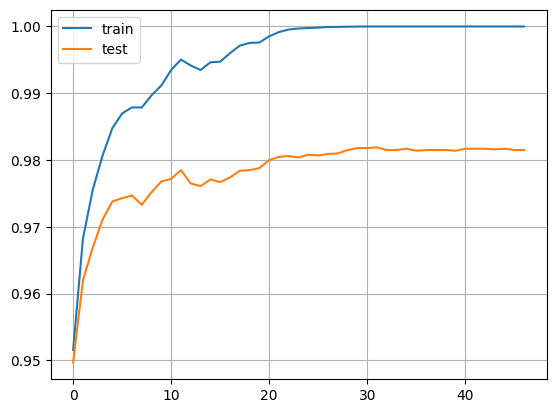

In [52]:
plt.plot(history["accuracy_train"], label="train")
plt.plot(history["accuracy_test"], label="test")
plt.grid(True)
plt.legend()
plt.show()

In [58]:
getTestAccuracy(X_test, Y_test, W1, b1, W2, b2)

0.9815

Prediction: [3]
Label: 3


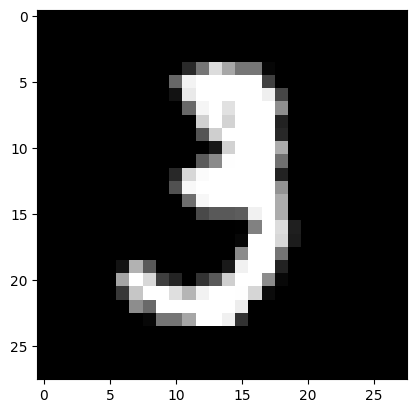

Prediction: [0]
Label: 0


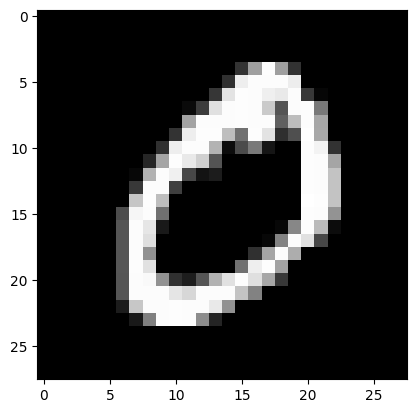

Prediction: [4]
Label: 4


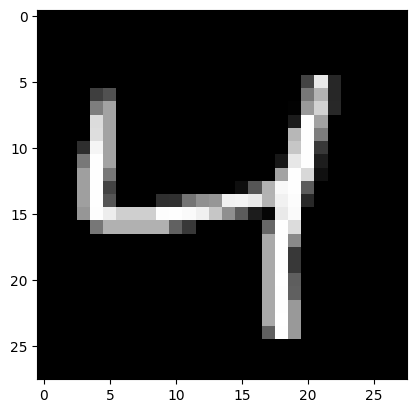

In [57]:
testPrediction(10, W1, b1, W2, b2)
testPrediction(1, W1, b1, W2, b2)
testPrediction(2, W1, b1, W2, b2)